# Final Report:

Gorden Li 489716

![Imgur](https://i.imgur.com/4HJknC2.png)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
!unzip -q "/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/DAT 565E Final/Wave_mel_black.zip" -d /content/

In [59]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/DAT 565E Final/label.csv")

In [62]:
df['emotion']= df['emotion'].astype('string')
df.head(10)

,filename,emotion
0,03-01-01-01-01-01-01.png,1
1,03-01-01-01-01-01-02.png,1
2,03-01-01-01-01-01-03.png,1
3,03-01-01-01-01-01-04.png,1
4,03-01-01-01-01-01-05.png,1
5,03-01-01-01-01-01-06.png,1
6,03-01-01-01-01-01-07.png,1
7,03-01-01-01-01-01-08.png,1
8,03-01-01-01-01-01-09.png,1
9,03-01-01-01-01-01-10.png,1


In [63]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,train_size=0.999)
train_df, validation_df = train_test_split(train_df,train_size=0.8)
print("Training shape :\t",train_df.shape)
print("Validation shape :\t",validation_df.shape)
print("Testing X shape :\t",test_df.shape)

Training shape :	 (1150, 2)
Validation shape :	 (288, 2)
Testing X shape :	 (2, 2)


In [64]:
train_df.groupby(by='emotion').count()

,filename
emotion,
1,75
2,162
3,153
4,154
5,159
6,149
7,152
8,146


In [65]:
train_df.head(10)

,filename,emotion
467,03-01-03-02-02-02-12.png,3
1213,03-01-07-02-02-01-14.png,7
1304,03-01-08-01-02-01-09.png,8
909,03-01-06-01-01-02-22.png,6
575,03-01-04-01-02-02-24.png,4
522,03-01-04-01-01-02-19.png,4
27,03-01-01-01-01-02-04.png,1
241,03-01-02-02-02-01-02.png,2
101,03-01-02-01-01-01-06.png,2
674,03-01-05-01-01-01-03.png,5


### Configure data generator
<font color="orange"><b>Todo:</b></font>

Now, let's configure **3** generators: for training, validation, test respectively, in the code chunk below.
 
\
**Note**: \
(1) Simply rescale input to `1./255`.
You don't need to perform augmentations such as rotation, zooming, and so on. The reason is that the testing images is exactly the same as training images.

(2) Here's a very helpful link about how to use the `flow_from_dataframe` API\
https://keras.io/api/preprocessing/image/

**Q: What is shuffle = True, how do we set target size?What does batch_size = 32 mean here since we will set another batch_size in model_fit**

In [66]:
from PIL import Image
Image.open("/content/Wave_mel_black/03-01-01-01-01-01-01.png").mode

'L'

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

target_size_set = (288, 720)

train_datagen = ImageDataGenerator(rescale=1./255) # Your code here ...
train_gen = train_datagen.flow_from_dataframe(
       train_df,
       directory='/content/Wave_mel_black',# Your code he,re..
       target_size=target_size_set,
       color_mode='grayscale',
       class_mode='categorical',# Your code here..
       x_col='filename',# Your code here..
       y_col='emotion',# Your code here..
       batch_size=32,
       shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)# Your code here ...
val_gen = val_datagen.flow_from_dataframe(
      validation_df,
      directory='/content/Wave_mel_black',# Your code here..
      target_size=target_size_set,
      color_mode='grayscale',
      class_mode='categorical',# Your code here..
      x_col='filename',# Your code here..
      y_col='emotion',# Your code here..
      batch_size=32)
    
test_datagen = ImageDataGenerator(rescale=1./255)# Your code here ...
test_gen = test_datagen.flow_from_dataframe(
      test_df,
      directory='/content/Wave_mel_black',# Your code here..
      target_size=target_size_set,
      color_mode='grayscale',      
      class_mode='categorical',# Your code here..
      x_col='filename',# Your code here..
      y_col='emotion')# Your code here..

Found 1150 validated image filenames belonging to 8 classes.
Found 288 validated image filenames belonging to 8 classes.
Found 2 validated image filenames belonging to 2 classes.


In [18]:
train_gen.n

1150

#### CNN
Relu function is used to avoid vanishing gradient. Dropout and early stop is used to avoid overfitting.

You can use any hyperparameters and improve your results here. 

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, LSTM, Conv1D, MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

model=Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),padding = 'same',input_shape=(288,720,1),activation="relu"))
model.add(Conv2D(64, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))
model.add(Conv2D(128, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(Conv2D(256, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))
model.add(Conv2D(512, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(Conv2D(512, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())

model.add(Dropout(0.25))
model.add(Dense(128,activation="relu", kernel_regularizer="l2"))
model.add(Dropout(0.25))                                                  
model.add(Dense(32,activation="relu")) 
model.add(Dense(8,activation="softmax"))

model.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_331 (Conv2D)          (None, 288, 720, 32)      320       
_________________________________________________________________
conv2d_332 (Conv2D)          (None, 288, 720, 64)      18496     
_________________________________________________________________
max_pooling2d_208 (MaxPoolin (None, 96, 240, 64)       0         
_________________________________________________________________
dropout_174 (Dropout)        (None, 96, 240, 64)       0         
_________________________________________________________________
conv2d_333 (Conv2D)          (None, 96, 240, 128)      73856     
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 96, 240, 256)      295168    
_________________________________________________________________
max_pooling2d_209 (MaxPoolin (None, 32, 80, 256)     

In [135]:
# Compile model
# Your code starts here..
model.compile(loss="categorical_crossentropy",
       optimizer="rmsprop",
       metrics=['accuracy'])

# Fit model. 
# Your code starts here.. 
Es=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, 
      epochs=50,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size,
      callbacks=[Es])

Epoch 1/50
35/35 [==============================] - 15s 399ms/step - loss: 1.8435 - accuracy: 0.4981 - val_loss: 1.6916 - val_accuracy: 0.4306
Epoch 2/50
35/35 [==============================] - 14s 391ms/step - loss: 1.4911 - accuracy: 0.5472 - val_loss: 1.8497 - val_accuracy: 0.4097
Epoch 3/50
35/35 [==============================] - 14s 390ms/step - loss: 1.3754 - accuracy: 0.5610 - val_loss: 1.8306 - val_accuracy: 0.4444
Epoch 4/50
35/35 [==============================] - 14s 390ms/step - loss: 1.3776 - accuracy: 0.5678 - val_loss: 1.8183 - val_accuracy: 0.4618


Solution: Im my CNN model, I use 2 3x3 Convolution layers and 2 2x2 pooling layers. The combination of these 2 layers is used to identify the main feature in the picture and lower the dimention. After flatterned, 20% dropout & l2 regularization is applied. Since the final output is non-negative continuous variable, 'relu' method is used in all activation function. Early stop set with patience at 3 is also applied to avoid overfiting

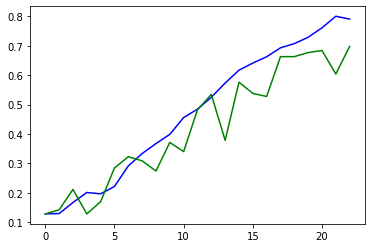

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='g')
plt.show()

# **CRNN**
Bi-directional LSTM is used in CRNN to simulate continuity of human emotion. Also, relu is used to avoid vanishing gradient. Early stop and dropout is used to avoid overfitting.

#### CNN + Bidictionary-LSTM

In [123]:
model=Sequential()
#CNN
model.add((Conv2D(32, kernel_size = (3, 3),padding = 'same',input_shape=(288,720,1),activation="relu")))
model.add(MaxPooling2D(pool_size=(3, 2)))
model.add(Conv2D(64, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 1)))
model.add(Conv2D(256, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 1)))
model.add(Dropout(0.4))
model.add(Conv2D(512, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(Conv2D(512, kernel_size = (3, 3),padding = 'same',activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 1)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Reshape((180,512)))

#Binary-LSTM
model.add(Bidirectional(LSTM(256,return_sequences=True,dropout=0.2,recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2,recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(16)))

model.add(Dense(8,activation="softmax"))

#Summary the model
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_325 (Conv2D)          (None, 288, 720, 32)      320       
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 96, 360, 32)       0         
_________________________________________________________________
conv2d_326 (Conv2D)          (None, 96, 360, 64)       18496     
_________________________________________________________________
max_pooling2d_204 (MaxPoolin (None, 32, 180, 64)       0         
_________________________________________________________________
dropout_171 (Dropout)        (None, 32, 180, 64)       0         
_________________________________________________________________
conv2d_327 (Conv2D)          (None, 32, 180, 128)      73856     
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 10, 180, 128)    

In [130]:
# Compile model
# Your code starts here..
model.compile(loss="categorical_crossentropy",
       optimizer="rmsprop",
       metrics=['accuracy'])

# Fit model. 
# Your code starts here.. 
Es=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, 
      epochs=50,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size,
      callbacks=[Es])

Epoch 1/50
35/35 [==============================] - 117s 3s/step - loss: 1.6599 - accuracy: 0.3814 - val_loss: 1.9271 - val_accuracy: 0.2569
Epoch 2/50
35/35 [==============================] - 101s 3s/step - loss: 1.5472 - accuracy: 0.4201 - val_loss: 1.8400 - val_accuracy: 0.3056
Epoch 3/50
35/35 [==============================] - 101s 3s/step - loss: 1.5336 - accuracy: 0.4283 - val_loss: 1.8114 - val_accuracy: 0.3056
Epoch 4/50
35/35 [==============================] - 102s 3s/step - loss: 1.5271 - accuracy: 0.4289 - val_loss: 1.7906 - val_accuracy: 0.3264
Epoch 5/50
35/35 [==============================] - 101s 3s/step - loss: 1.5345 - accuracy: 0.4378 - val_loss: 1.8759 - val_accuracy: 0.2882
Epoch 6/50
35/35 [==============================] - 101s 3s/step - loss: 1.4934 - accuracy: 0.4319 - val_loss: 1.9276 - val_accuracy: 0.3056
Epoch 7/50
35/35 [==============================] - 101s 3s/step - loss: 1.4594 - accuracy: 0.4339 - val_loss: 1.8258 - val_accuracy: 0.3264
